In [37]:
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import norm

import html
import urllib

from helper_functions import *

Reading data
------------

In [2]:
graphs_path = './data/wikispeedia_paths-and-graph/'

In [3]:
link_network = read_tsv('links', names=['source', 'target'])
categories = read_tsv('categories')
finished_paths = read_tsv('paths_finished')
unfinished_paths = read_tsv('paths_unfinished')
articles = read_tsv('articles')

Functions
------------

In [4]:
def article_length(article_name):
    ''' Compute the average length of an article, i.e. the number of words'''
    article_path = './data/plaintext_articles/'
    article = article_path + article_name + '.txt'
    
    nb_words = 0
    with open(article) as f:
        for line in f:
            nb_words += len(line.split())
    return nb_words

def get_avg_duration(row):
    ''' Compute the average duration spent per articles'''
    num_steps = len(row['path'].split(';')) - 1
    return np.nan if num_steps <= 0 else row['durationInSec'] / num_steps

def avg_article_length(path):
    '''Compute the average article lenght (i.e. nb of words) along a path of articles'''
    avg_article_length = []
    for index, row in path.iterrows():
        articles = row['path'].split(';')
        articles_length = []
        for art in articles:
            if art != '<': #Not considering backcliks
                articles_length.append(article_length(art))
        avg_article_length.append(np.mean(articles_length))
    return avg_article_length

def avg_target_source_ratio(path):
    ''' Compute the average ratio of incoming and outgoing links in articles along a path'''
    avg_target_source_ratio = []
    for index, row in path.iterrows():
        articles = row['path'].split(';')
        target_source_ratio = []
        if '<' in articles: #Not considering backcliks
            target_source_ratio.append(float('nan'))
        else:
            for art in articles:
                if art in list(link_counts['article']):
                    target_source_ratio.append(link_counts[link_counts['article']==art]['target_source_ratio'].values[0])
                else:
                    target_source_ratio.append(float('nan'))
        avg_target_source_ratio.append(np.nanmean(target_source_ratio))
    
    return avg_target_source_ratio

def calculate_positions(arts):
    ''' Compute the relative position of links clicked in a path'''
    # ignore backclicks
    if '<' in arts: return [float('nan')]
    
    articles = arts.split(';')
    
    # ignore paths without actual steps
    if len(articles) < 2: return [float('nan')]
    
    positions = []
    
    art_idx = 0
    
    for idx, art in enumerate(articles[1:]):
        art0 = articles[art_idx]
        try:          
            positions.append(link_network_pos[(link_network_pos['source'] == art0)
                            & (link_network_pos['target'] == art)]['position'].values[0])
            art_idx = idx+1
        except:
            print(art0, art, arts)
            return [float('nan')]
    
    return positions

def normalize(data, column_name):
    ''' Normalize a column in a dataframe '''
    return (data[column_name] - data[column_name].mean())/data[column_name].std()

Phase 2: Exploratory Data Analysis
------------

### Article metrics

In [5]:
# Ratio of of incoming and outgoing links for each article: 
source_counts = link_network['source'].value_counts().rename_axis('article').reset_index(name='source_count')
target_counts = link_network['target'].value_counts().rename_axis('article').reset_index(name='target_count')

link_counts = pd.merge(source_counts, target_counts, how='outer')
link_counts.fillna(0, inplace=True)

link_counts['target_source_ratio'] = link_counts['target_count'] / link_counts['source_count']
link_counts['target_source_ratio'].replace([np.inf], np.nan, inplace=True)

In [6]:
display(link_counts.head(5))
link_counts.shape

,article,source_count,target_count,target_source_ratio
0,United_States,294.0,1551.0,5.275510
1,Driving_on_the_left_or_right,255.0,0.0,0.000000
2,List_of_countries,244.0,63.0,0.258197
3,List_of_circulating_currencies,236.0,8.0,0.033898
4,List_of_sovereign_states,216.0,43.0,0.199074


(4592, 4)

In [7]:
# Length of articles (i.e. nb of words):
link_counts['article_length'] = link_counts['article'].apply(lambda x: article_length(x))

In [8]:
display(link_counts.head(5))
link_counts.shape

,article,source_count,target_count,target_source_ratio,article_length
0,United_States,294.0,1551.0,5.275510,9773
1,Driving_on_the_left_or_right,255.0,0.0,0.000000,7995
2,List_of_countries,244.0,63.0,0.258197,3162
3,List_of_circulating_currencies,236.0,8.0,0.033898,3019
4,List_of_sovereign_states,216.0,43.0,0.199074,5586


(4592, 5)

In [ ]:
# Positions of links within the articles: (takes time to compute, load the dataframe instead)

# Remove links to and from non-Wikipedia articles (donation pages)
#link_network = filter_rows_by_values(link_network, 'source', ['Friend_Directdebit', 'Sponsorship_Directdebit'])
#link_network_targets = link_network.groupby('source')['target'].apply(list).reset_index()

# Add the 'html_position' column to the DataFrame
#link_network_targets['html_position'] = link_network_targets.apply(
#    lambda row: find_html_position(row['source'], row['target']), axis=1
#)

#display(link_network_targets.head(5))
#link_network_targets.shape

In [9]:
# Load the data (postisions of link already computed) 
link_network_pos = pd.read_pickle('link_network_w_position.df')

In [10]:
display(link_network_pos.head(5))
link_network_pos.shape

,source,target,position
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,0.037459
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,0.025523
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,0.058024
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,0.032042
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man,0.063349


(119878, 3)

In [11]:
# Identify main categories and sublevels of categories:
main_cat_set = set()
sec_cat_set = set()
thrd_cat_set = set()

for cat in categories['category']:
    levels = cat.split('.')
    if len(levels) > 1:
        main_cat_set.add(levels[1])
    if len(levels) > 2:
        sec_cat_set.add(levels[2])
    if len(levels) > 3:
        thrd_cat_set.add(levels[3])

In [12]:
print(f'There are {len(main_cat_set)} unique main categories, {len(sec_cat_set)} unique second level categories, and {len(thrd_cat_set)} unique third level categories.')

There are 15 unique main categories, 101 unique second level categories, and 27 unique third level categories.


### Player path specific metrics

In [ ]:
# These steps take time to execute, load the dataframes to have the already computed values

In [13]:
# Average duration per articles:
#finished_paths['avg_duration'] = finished_paths.apply(get_avg_duration, axis=1)
#unfinished_paths['avg_duration'] = unfinished_paths.apply(get_avg_duration, axis=1)

In [ ]:
# Position of links:
#finished_paths['link_positions'] = finished_paths['path'].apply(calculate_positions)
#unfinished_paths['link_positions'] = unfinished_paths['path'].apply(calculate_positions)

In [ ]:
# Average positions of links clicked for each path:
#finished_paths['avg_position'] = finished_paths['link_positions'].apply(
#    lambda x: np.mean(x) if x else np.nan)
#unfinished_paths['avg_position'] = unfinished_paths['link_positions'].apply(
#    lambda x: np.mean(x) if x else np.nan)

In [ ]:
# Average article length:
#finished_paths['avg_article_length'] = avg_article_length(finished_paths)
#unfinished_paths['avg_article_length'] = avg_article_length(unfinished_paths)

In [ ]:
# Average ratio of incoming and outgoing links for all article in paths
#finished_paths['avg_target_source_ratio'] = avg_target_source_ratio(finished_paths)
#unfinished_paths['avg_target_source_ratio'] = avg_target_source_ratio(unfinished_paths)

In [215]:
#finished_paths.to_pickle('finished_paths_w_positions.df')
#unfinished_paths.to_pickle('unfinished_paths_w_positions.df')

In [13]:
# Load data with positions
finished_paths = pd.read_pickle('finished_paths_w_positions.df')
unfinished_paths = pd.read_pickle('unfinished_paths_w_positions.df')

In [14]:
display(finished_paths.head(5))
finished_paths.shape
display(unfinished_paths.head(5))
unfinished_paths.shape

,hashedIpAddress,timestamp,durationInSec,path,rating,link_positions,avg_duration,avg_position,max_position,avg_article_length,avg_target_source_ratio
0,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"[0.16301315265045835, 0.0320129127715381, 0.23...",17.600000,0.161321,0.238708,4322.400000,2.191707
1,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,"[0.38341968911917096, 0.04472755782046257, 0.0...",17.250000,0.189159,0.383420,5570.875000,1.300951
2,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,"[0.43304105221203665, 0.2143170488534397, 0.04...",9.250000,0.229568,0.433041,4011.000000,2.223104
3,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,"[0.14806695894778796, 0.055970351133474004, 0....",25.000000,0.284119,0.983090,6885.714286,2.969612
4,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN,"[0.16301315265045835, 0.3061066648732262, 0.43...",18.333333,0.263157,0.432730,4909.000000,3.750072


,hashedIpAddress,timestamp,durationInSec,path,target,type,link_positions,avg_duration,max_position,avg_position,avg_article_length,avg_target_source_ratio
0,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,[nan],1805.00,NaN,NaN,7586.0,2.333333
1,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,"[0.020996711358461928, 0.24676118775557]",606.00,0.246761,0.133879,5604.0,1.773224
2,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,[nan],49.00,NaN,NaN,1327.0,1.950000
3,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,[0.16173641173641173],904.00,0.161736,0.161736,3352.0,1.532377
4,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout,"[0.0487655079228596, 0.12396390951476428, 0.50...",502.25,0.507053,0.226594,4338.0,2.724478


(24874, 12)

### Player specific information

In [15]:
players = pd.concat([unfinished_paths, finished_paths])

In [16]:
# Number of games per player
player_game_counts = players.groupby('hashedIpAddress')['path'].count().reset_index()
player_game_counts.columns = ['player_hash', 'games_count']

In [17]:
# Win rate:
player_game_counts['finished_paths_count'] = player_game_counts['player_hash']\
                                             .map(finished_paths['hashedIpAddress']\
                                             .value_counts().fillna(0))
player_game_counts['win_rate'] = player_game_counts['finished_paths_count'] / player_game_counts['games_count']
player_game_counts['win_rate'].fillna(0, inplace=True)

In [18]:
display(player_game_counts.head(5))
player_game_counts.shape

,player_hash,games_count,finished_paths_count,win_rate
0,000386124f307de8,2,1.0,0.5
1,0007183207b6008f,3,3.0,1.0
2,000a09e202e88d10,1,1.0,1.0
3,000a5bac5b7781ea,1,1.0,1.0
4,000a6e585b776c96,1,NaN,0.0


(20866, 4)

Phase 4:  Comparative Analysis and Statistical Modeling
------------

### Feature Impact Assessment

The features to consider are: the average length of articles in each path (`avg_article_length`), the average position of links used along a path (`avg_position`) and the average ratio of incoming and outgoing links for each article in the path (`avg_target_source_ratio`).  

In [19]:
# Binary indicator of whether a player completed a path (1) or not (0):
paths = pd.concat([finished_paths, unfinished_paths])
paths['completion'] = [1]*len(finished_paths) + [0]*len(unfinished_paths)

In [20]:
# Standardize the countinuous features
paths_normalized = paths.copy()
paths_normalized['avg_article_length'] = normalize(paths_normalized, 'avg_article_length')
paths_normalized['avg_position'] = normalize(paths_normalized, 'avg_position')
paths_normalized['avg_target_source_ratio'] = normalize(paths_normalized, 'avg_target_source_ratio')

In [21]:
# Model 1: dependent variable = completion, so logistic regression (binary outcome)
mod1 = smf.logit(formula='completion ~  avg_article_length + avg_position + avg_target_source_ratio', 
                 data=paths_normalized)
res1 = mod1.fit()
print(res1.summary())

Optimization terminated successfully.
         Current function value: 0.565335
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             completion   No. Observations:                56710
Model:                          Logit   Df Residuals:                    56706
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                0.002341
Time:                        21:13:29   Log-Likelihood:                -32060.
converged:                       True   LL-Null:                       -32135.
Covariance Type:            nonrobust   LLR p-value:                 2.127e-32
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.0873      0.010    111.560      0.000       1.068   

**I** The pseudo R-squared is very low, meaning that the model does not fit well the data. Our features does not seem to explain well the completion variable. This result show that the global architecture of the articles along a Wikispeedia path does not really impact the completion of the path.  

In [22]:
# Visualisation of the influence of each feature
variables_model1 = res1.params.index #features
coefficients_model1 = res1.params.values
p_values_model1 = res1.pvalues
standard_errors_model1 = res1.bse.values
res1.conf_int() #confidence intervals

,0,1
Intercept,1.068209,1.106414
avg_article_length,0.022764,0.062388
avg_position,-0.021980,0.016150
avg_target_source_ratio,-0.138252,-0.099012


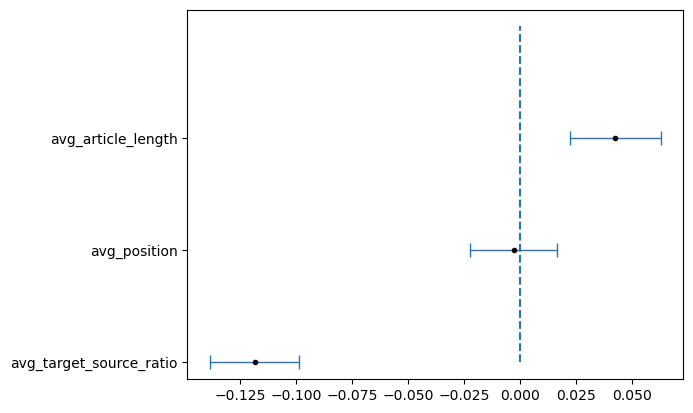

In [23]:
# Sort by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_model1[1:], variables_model1[1:], 
                                 standard_errors_model1[1:], p_values_model1[1:])))

# Plotting
plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)
plt.vlines(0,0, len(l1), linestyle = '--')
plt.yticks(range(len(l2)),l2);

**I** The `avg_position` has almost no contribution to the completion variable. However, the higher the `avg_article_length` and the lower the `avg_target_source_ratio`, the more likely the path is completed.

In [24]:
# Model 2: dependent variable = avg_duration, so linear regression (continuous outcome)
mod2 = smf.ols(formula='avg_duration ~  avg_article_length + avg_position + avg_target_source_ratio', 
                 data=paths_normalized)
res2 = mod2.fit()
print(res2.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:           avg_duration   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     18.25
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           7.81e-12
Time:                        21:13:29   Log-Likelihood:            -3.7537e+05
No. Observations:               56710   AIC:                         7.508e+05
Df Residuals:                   56706   BIC:                         7.508e+05
Df Model:                           3                                         
Covariance Type:            nonrobust  

**I** The R-squared is also very low, our features does not explain a lot of the variability in the average duration of games.  

In [25]:
# Visualization of the contributiono of each feature
variables_model2 = res2.params.index #features
coefficients_model2 = res2.params.values
p_values_model2 = res2.pvalues
standard_errors_model2 = res2.bse.values
res2.conf_int() #confidence intervals

,0,1
Intercept,74.973875,77.974198
avg_article_length,-1.257313,1.860246
avg_position,4.102241,7.107048
avg_target_source_ratio,-0.258993,2.975030


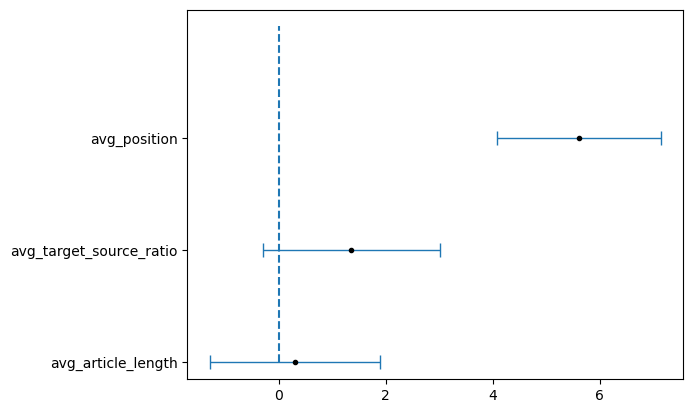

In [26]:
# Sort by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_model2[1:], variables_model2[1:], 
                                 standard_errors_model2[1:], p_values_model2[1:])))

# Plotting
plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)
plt.vlines(0,0, len(l1), linestyle = '--')
plt.yticks(range(len(l2)),l2);

**I** The `avg_article_length` almost not contribute to the `avg_duration` of the game while the `avg_position` contributes the most. The higher `avg_position` and `avg_target_source ratio`, the higher the time spend in each article. 

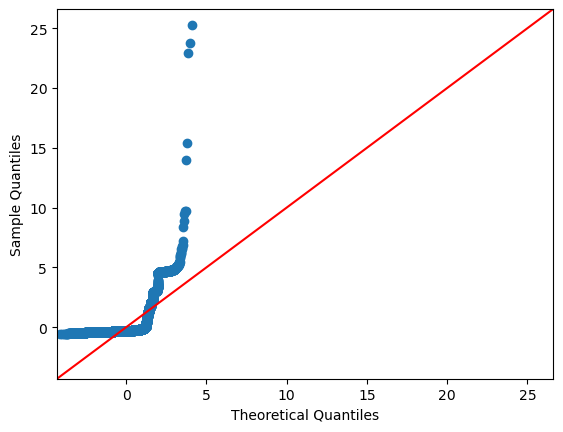

In [39]:
# Test normality of the residuals
fig = sm.graphics.qqplot(res2.resid, dist=norm, line='45', fit=True)

The normality of residuals is clearly not respected. We try to log-transform the dependent variable (`avg_duration`) to improve the model and makes the residuals more normal. 

The model 2 is then re-run but this time the log of the `avg_duration`. 

In [27]:
# Model 2 but with log of avg_duration:
paths_normalized['log_avg_duration'] = np.log(paths_normalized['avg_duration'])

mod2_log = smf.ols(formula='log_avg_duration ~  avg_article_length + avg_position + avg_target_source_ratio', 
                   data=paths_normalized)
res2_log = mod2_log.fit()
print(res2_log.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:       log_avg_duration   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     400.6
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.58e-257
Time:                        21:13:29   Log-Likelihood:                -90248.
No. Observations:               56710   AIC:                         1.805e+05
Df Residuals:                   56706   BIC:                         1.805e+05
Df Model:                           3                                         
Covariance Type:            nonrobust  

/Users/marielouhirschy/anaconda3/envs/ada/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


**I** The R-squared increased compared to without the log transform, but not much. 

In [28]:
# Visualization of the contribution of each feature 
variables_model2_log = res2_log.params.index #features
coefficients_model2_log = res2_log.params.values
p_values_model2_log = res2_log.pvalues
standard_errors_model2_log = res2_log.bse.values
res2_log.conf_int() #confidence intervals

,0,1
Intercept,3.229529,3.249190
avg_article_length,0.021420,0.041850
avg_position,0.163486,0.183177
avg_target_source_ratio,0.007470,0.028664


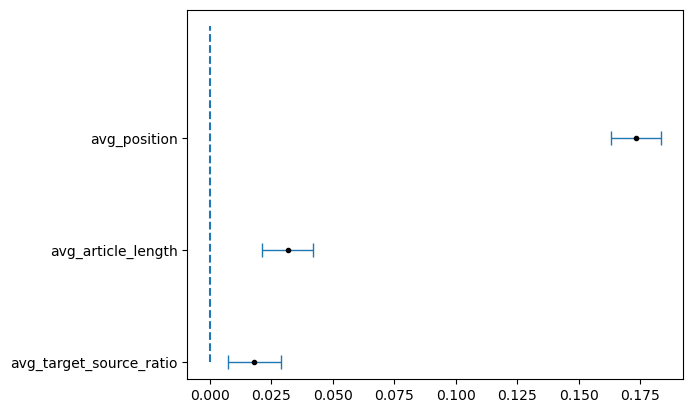

In [29]:
# Sort by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_model2_log[1:], variables_model2_log[1:], 
                                 standard_errors_model2_log[1:], p_values_model2_log[1:])))

# Plotting
plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)
plt.vlines(0,0, len(l1), linestyle = '--')
plt.yticks(range(len(l2)),l2);

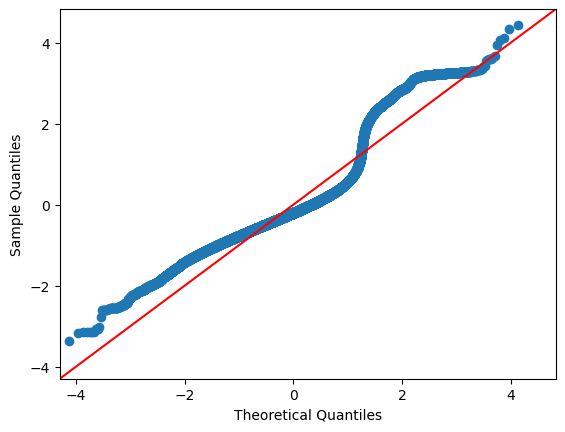

In [38]:
# Test normality of the residuals
fig = sm.graphics.qqplot(res2_log.resid, dist=norm, line='45', fit=True)

Actually, normality is still not respected but it improved with the log-transform. 

To improve again the model, all the variables are log-transformed.

In [40]:
# Model 2 with all variables log-transformed
paths_normalized['log_avg_article_length'] = np.log(paths_normalized['avg_article_length'])
paths_normalized['log_avg_position'] = np.log(paths_normalized['avg_position'])
paths_normalized['log_avg_target_source_ratio'] = np.log(paths_normalized['avg_target_source_ratio'])

mod2_loglog = smf.ols(formula='log_avg_duration ~  log_avg_article_length + log_avg_position +\
                               log_avg_target_source_ratio', 
                   data=paths_normalized)
res2_loglog = mod2_loglog.fit()
print(res2_loglog.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:       log_avg_duration   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     29.37
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           7.72e-19
Time:                        21:32:11   Log-Likelihood:                -8950.5
No. Observations:                5704   AIC:                         1.791e+04
Df Residuals:                    5700   BIC:                         1.794e+04
Df Model:                           3                                         
Covariance Type:            nonrobust  

/Users/marielouhirschy/anaconda3/envs/ada/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/marielouhirschy/anaconda3/envs/ada/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/marielouhirschy/anaconda3/envs/ada/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


This time, the R-squared decreases, so our model does not improve. 